In this notebook, we implement and test the image caption geneartor proposed in [1].

[1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk

import keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, Concatenate, Lambda, Reshape
from tensorflow.keras import losses, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

Using TensorFlow backend.


# Mount Google Drive


In [ ]:
if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('/drive/My Drive/2IMM10/assignments/assignment3/')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Download Data - Flickr8k

We use a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

Since the dataset was requested not to be distributed, loading it has not been included in here.

# Extracting Image Representations

Let us use the conv_1 layer from the *MobileNetV2* network to generate neural codes for each image.

In [ ]:
def get_image_codes(images):      
  convnet = MobileNetV2(input_shape=(128,128,3), 
                          include_top=False, 
                          weights='imagenet')
  # convnet.summary()

  # Normalize the images to bein range [-1, 1]
  normalized_images = 2.*(images - np.min(images)) / np.ptp(images) - 1
  print(f"Minimum value: {np.min(normalized_images)}\nMaximum value: {np.max(normalized_images)}")

  # Use Conv_1 of MobileNetV2 to generate neural codes
  image_codes_model = Model(convnet.input, convnet.get_layer('Conv_1').output)
  
  # Predict in batches to reduce stress on GPU
  image_codes = image_codes_model.predict(normalized_images, batch_size=batch_size)
  
  # Reshape the neural codes
  image_codes = np.reshape(image_codes, (8091, 20480))

  return image_codes

image_codes = get_image_codes(images)
print(image_codes.shape)

9412608/9406464 [==============================] - 1s 0us/step
Minimum value: -1.0
Maximum value: 1.0
(8091, 20480)


# Analyze Captions

Let us create some structures that we need later on in order to analyze the captions.

In [ ]:
from itertools import chain
from collections import Counter


max_caption_length = max([len(subcap) for caption in captions for subcap in caption])

word_collection = [word for caption in captions for subcap in caption for word in subcap]
# We assign '_' a count of 100000 just so it will be in front. This makes the next step easier where we have to 
# add indices to the words.
word_dict = Counter(word_collection) + Counter({'_': 100000})

word_to_idx = {val[0]:index for index, val in enumerate(word_dict.most_common())}

idx_to_word = {v: k for k, v in word_to_idx.items()}

num_words = [*idx_to_word.keys()][-1] + 1

print(f"Max caption length: {max_caption_length}\nTen most common words: {word_dict.most_common(11)[1:]}\nNum_words: {num_words}\nWord_dict: {word_dict}\nWord_to_idx: {word_to_idx}\nIdx_to_word: {idx_to_word}")

Max caption length: 35
Ten most common words: [('a', 62986), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713)]
Num_words: 2992
Word_dict: Counter({'_': 100000, 'a': 62986, 'in': 18974, 'the': 18418, 'on': 10743, 'is': 9345, 'and': 8851, 'dog': 8136, 'with': 7765, 'man': 7265, 'of': 6713, 'two': 5638, 'white': 3940, 'black': 3832, 'boy': 3581, 'are': 3504, 'woman': 3402, 'girl': 3328, 'to': 3173, 'wearing': 3062, 'at': 2914, 'people': 2883, 'water': 2783, 'red': 2672, 'young': 2630, 'brown': 2563, 'an': 2432, 'his': 2357, 'blue': 2268, 'dogs': 2125, 'running': 2073, 'through': 2032, 'playing': 2008, 'while': 1968, 'down': 1825, 'shirt': 1806, 'standing': 1787, 'ball': 1779, 'little': 1768, 'grass': 1622, 'child': 1545, 'person': 1542, 'snow': 1492, 'jumping': 1472, 'over': 1414, 'front': 1386, 'three': 1381, 'sitting': 1368, 'holding': 1324, 'field': 1280, 'small': 1278, 'up': 1260, 'by': 1248, 'large':

#### The 10 most frequent words

We observe that the 10 most frequent words are 'a', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', and 'of'. Most of these words are function words. This is to be expected since many, if not all, captions consist of several function words. We notice that especially articles and prepositions are present.

On the other hand, we also observe the content words 'dog' and 'man'. After closer observation, we see that 'man' has 7265 occurrences, whereas 'woman' has 3402 (this word is not in the top 10, but it is relevant for the bias). From this observation, we definitely believe there is some bias in the dataset. We also suspect this bias will become apparent in the predicted captions. We suspect there will be cases where the predicted caption calls a person a 'man' while the person is, in fact, a 'woman'. If the model predicts a caption for an image, where the gender is unidentifiable (e.g., only the back of the person can be seen and the person is wearing a hoody), the model is more likely to predict a caption referring to that person as a 'man' rather than as a 'woman' due to the bias in the dataset. Something similar might happen with the content word 'dog'. Several of the predicted captions might call an animal with a similar shape to a dog, a dog.

# Train/Validation/Test Split

In [ ]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]

# Convert Train and Validation Data into Matrix Format

This encodes the captions to integer matrices using the mapping *word_to_idx*. 
It also duplicates the corresponding image codes.
The result is two matrices {train, val}_codes and {train, val}_y, which hold image codes and integer encoded captions, whose rows correspond to each other.

In [ ]:
def convert_data(codes, captions, max_caption_length, word_to_idx):
  if codes.shape[0] != len(captions):
    raise AssertionError("Different number of codes and captions.")

  N = codes.shape[0]
  duplicate_codes = None
  labels = None
  for k in range(5):
    cur_labels = np.zeros((N, max_caption_length), dtype=np.uint32)
    for l in range(N):
      for count, w in enumerate(captions[l][k]):
        cur_labels[l, count] = word_to_idx[w]

    if duplicate_codes is None:
      duplicate_codes = codes
      labels = cur_labels
    else:
      duplicate_codes = np.concatenate((duplicate_codes, codes), 0)
      labels = np.concatenate((labels, cur_labels), 0)
  
  return duplicate_codes, labels

train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(30455, 20480)
(30455, 35)
(5000, 20480)
(5000, 35)


# Show Random Images from Train and Validation Sets


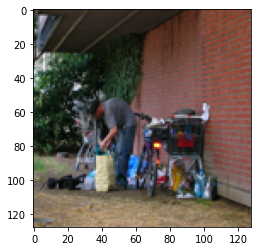

['a', 'man', 'with', 'a', 'shopping', 'bag', 'outside', 'near', 'a', 'shopping', 'cart', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





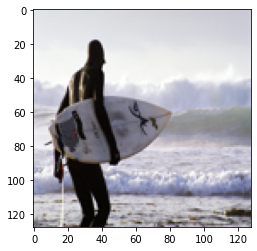

['a', 'man', 'in', 'a', 'wetsuit', 'with', 'a', 'surfboard', 'walks', 'along', 'a', 'beach', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





In [ ]:
def show_random_image_and_captions(images, labels, idx_to_word):
  n = images.shape[0]
  idx = np.random.randint(0, n)

  plt.imshow(images[idx % images.shape[0], ...])
  plt.show()

  encoded_caption = labels[idx, ...]
  encoded_caption = [k for k in encoded_caption if k >= 0]
  caption = [idx_to_word[i] for i in encoded_caption]
  print(caption)
  print('\n\n')

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)

# Creating The Model

The model takes two inputs:

*   *image_input*: placeholder for image codes.
*   *caption_inputs*: placeholder for integer-encoded captions. 

We then use the following structure:

*   Image embedding: *Dense* layer, mapping image codes to embeddings of length *embedding_dim*.
*   Caption embedding: *Embedding* layer, mapping integers to embeddings of length *embedding_dim*.
*   Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
*   LSTM with *lstm_dim* units, taking the concatenated embedding as input.
*   Apply Dropout with rate 0.5 to the LSTM.
*   Output layer: *Dense* layer, mapping the output of the LSTM to a categorical distribution (via *softmax*) of length *num_words*.



In [ ]:
def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

  # inputs
  image_input = Input(shape=(code_length,), name='image_input')
  caption_input = Input(shape=(max_caption_length - 1,), name='caption_input')

  image_embedding = Dense(embedding_dim, name='image_embedding')(image_input)
  caption_embedding = Embedding(num_words, embedding_dim, input_length=max_caption_length, name='caption_embedding')(caption_input)
  expanded_image_embedding = K.expand_dims(image_embedding, 1)
  embedding = Concatenate(axis=1)([expanded_image_embedding, caption_embedding])
  lstm = LSTM(lstm_dim, return_sequences=True, dropout=lstm_dropout, name='lstm')(embedding)
  output = Dense(num_words, activation='softmax', name='output')(lstm)

  return Model([image_input, caption_input], output)

model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 20480)]      0                                            
__________________________________________________________________________________________________
image_embedding (Dense)         (None, 512)          10486272    image_input[0][0]                
__________________________________________________________________________________________________
caption_input (InputLayer)      [(None, 34)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 1, 512)]     0           image_embedding[0][0]            
____________________________________________________________________________________________

We are expected to predict each word of the caption after it has seen the image codes as well as the preceding word of the true caption. Note that we do not need the last word of the true caption as input since we do not want to predict a word after the final word. For this, we need to concatenate the image codes and the embedding of the true caption. Since we want to predict 35 words, we use 35 timesteps.
More specifically, at time $t=0$, we feed the LSTM the image codes, and the LSTM uses this to predict the first word of the caption. Then, at time $t = 1$, the LSTM only uses its internal state and the embedding of the first word of the true caption as input to predict the second word of the caption. This is repeated for the other time steps. To generalize, at time $t = i$ with $1 \leq i \leq T - 1$, the LSTM gets as input the previous internal state (from time $i - 1$) and the embedding of the $i$th word of the true caption to predict the $(i + 1)$th word of the predicted caption. Note that the image codes are only given as input directly at time $t = 0$, and only one word is given at each of the following $T - 1$ timesteps.


# Training The Model

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=1,
                                        verbose=1, 
                                        mode='auto')

optimizer = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit([train_codes, train_y[:,:34]], train_y, batch_size=batch_size, epochs=100, callbacks=early_stopping_callback, 
          validation_data=([val_codes, val_y[:,:34]], val_y))

Epoch 1/100
305/305 [==============================] - 26s 84ms/step - loss: 1.6414 - accuracy: 0.7409 - val_loss: 1.3253 - val_accuracy: 0.7629
Epoch 2/100
305/305 [==============================] - 25s 82ms/step - loss: 1.2376 - accuracy: 0.7729 - val_loss: 1.1792 - val_accuracy: 0.7789
Epoch 3/100
305/305 [==============================] - 25s 82ms/step - loss: 1.1239 - accuracy: 0.7828 - val_loss: 1.1033 - val_accuracy: 0.7861
Epoch 4/100
305/305 [==============================] - 25s 82ms/step - loss: 1.0524 - accuracy: 0.7891 - val_loss: 1.0557 - val_accuracy: 0.7905
Epoch 5/100
305/305 [==============================] - 25s 82ms/step - loss: 1.0011 - accuracy: 0.7934 - val_loss: 1.0246 - val_accuracy: 0.7935
Epoch 6/100
305/305 [==============================] - 25s 83ms/step - loss: 0.9629 - accuracy: 0.7971 - val_loss: 1.0054 - val_accuracy: 0.7955
Epoch 7/100
305/305 [==============================] - 25s 83ms/step - loss: 0.9359 - accuracy: 0.7997 - val_loss: 0.9916 - val_ac

#### The input and the output of the model

We give the image codes and the integer encoded captions as input. Note that we only provide the first 34 words in the integer encoded captions as input since at timestep $i - 1$, where $1 \leq i \leq T$, we predict word $i$ in the caption using word $i-1$ from the integer encoded caption. At the last timestep, we cannot use the last word of the integer encoded caption to predict a new word in our caption since we already predicted the last word of our caption in the previous timestep. At timestep $i = 0$, the input is the embedding or neural code of the image of which we want to predict the caption.

The reason why we provide the image codes and the first 34 words of the integer encoded captions has been given in the previous text cell, namely: 

> We are expected to predict each word of the caption after it has seen the image codes as well as the preceding word of the true caption. Note that we do not need the last word of the true caption as input since we do not want to predict a word after the final word. For this, we need to concatenate the image codes and the embedding of the true caption. Since we want to predict 35 words, we use 35 timesteps.
More specifically, at time $t=0$, we feed the LSTM the image codes, and the LSTM uses this to predict the first word of the caption. Then, at time $t = 1$, the LSTM only uses its internal state and the embedding of the first word of the true caption as input to predict the second word of the caption. This is repeated for the other time steps. To generalize, at time $t = i$ with $1 \leq i \leq T - 1$, the LSTM gets as input the previous internal state (from time $i - 1$) and the embedding of the $i$th word of the true caption to predict the $(i + 1)$th word of the predicted caption. Note that the image codes are only given as input directly at time $t = 0$, and only one word is given at each of the following $T - 1$ timesteps.

We also provide the integer encoded captions as the target data (the true captions) in order to compute the sparse categorical cross-entropy. We also provide validation data such that we can use early stopping.

The output of the model is a sequence of 35 word integers, which represent the caption that our model predicts for the given image. Our model can, of course, also predict captions that have a length smaller than 35, e.g., 10, by simply appending 25 stop words, encoded in the dictionary as '_'.


# Evaluating The Model

In [ ]:
import pandas as pd

model.summary()

# Obtain the training, væalidation, and test metrics
training_results = model.evaluate([train_codes, train_y[:,:34]], train_y, batch_size=batch_size)
validation_results = model.evaluate([val_codes, val_y[:,:34]], val_y, batch_size=batch_size)

# Create a dataframe that stores the loss, accuracy, and top-k categorical accuracy for each type of data set
column_names = ["loss", "accuracy"]
df = pd.DataFrame(np.array([training_results, validation_results]), columns=column_names)
df["data"] = ["train", "val"]
df = df[["data", *column_names]]
df

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 20480)]      0                                            
__________________________________________________________________________________________________
image_embedding (Dense)         (None, 512)          10486272    image_input[0][0]                
__________________________________________________________________________________________________
caption_input (InputLayer)      [(None, 34)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF (None, 1, 512)       0           image_embedding[0][0]            
____________________________________________________________________________________________

,data,loss,accuracy
0,train,0.737204,0.822662
1,val,0.958060,0.802531


# Creating The Decoder

Let us create a greedy decoder model, which iteratively predicts the most likely word at each time step. The decoder is akin to the trained model above, but with a crucial difference: at time step t (t > 0), the LSTM takes the embedding of the word *predicted at time step t-1* as input. At time t=0, the LSTM takes the image embedding as input. 

The decoder returns the predicted caption, encoded as an integer matrix of shape (batch_size, max_caption_length).

In [ ]:
def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):
  
  # Input
  image_input = Input(shape=(code_length,), name='image_input')
  
  image_embedding = Dense(embedding_dim, name='image_embedding')(image_input)
  image_embedding_expanded = K.expand_dims(image_embedding, axis=1)

  outputs = []

  # Process the image embedding: predict the first word of the caption
  a, _, c = LSTM(lstm_dim, return_sequences=False, return_state=True, 
                                       dropout=lstm_dropout, name='lstm_0')(image_embedding_expanded)
  output = Dense(num_words, activation='softmax', name='prob_distribution_0')(a)
  x_output = Lambda(lambda x : K.expand_dims(K.argmax(x)))(output)
  outputs.append(x_output)
  x = Embedding(num_words, embedding_dim, name='embedding_0')(x_output)

  # Use the embedding of the previous word and use it to predict the next word
  for i in range(1, max_caption_length):
    a, _, c = LSTM(lstm_dim, return_sequences=False, return_state=True, 
                                       dropout=lstm_dropout, name='lstm_{0}'.format(i))(x, initial_state=[a, c])
    output = Dense(num_words, activation='softmax', name='prob_distribution_{0}'.format(i))(a)
    x_output = Lambda(lambda x : K.expand_dims(K.argmax(x)))(output)
    outputs.append(x_output)
    x = Embedding(num_words, embedding_dim, name='embedding_{0}'.format(i))(x_output)

  # Create the decoder model
  decoder_model = Model(image_input, outputs, name='decoder')

  # Initialise weights of the decoder model with the retrieved weights
  decoder_model.get_layer('image_embedding').set_weights(weights[0])
  for i in range(max_caption_length):
    decoder_model.get_layer('lstm_{0}'.format(i)).set_weights(weights[1])
    decoder_model.get_layer('prob_distribution_{0}'.format(i)).set_weights(weights[2])
    if i < max_caption_length - 1: decoder_model.get_layer('embedding_{0}'.format(i)).set_weights(weights[3])
  
  return decoder_model


# Get the weights from trained model, and put them in a list 'weights'.
embedding_weights = model.get_layer('image_embedding').get_weights()
lstm_weights = model.get_layer('lstm').get_weights()
output_weights = model.get_layer('output').get_weights()
caption_weights = model.get_layer('caption_embedding').get_weights()

weights = [embedding_weights, lstm_weights, output_weights, caption_weights]

decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 20480)]      0                                            
__________________________________________________________________________________________________
image_embedding (Dense)         (None, 512)          10486272    image_input[0][0]                
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_2 (Tenso [(None, 1, 512)]     0           image_embedding[0][0]            
__________________________________________________________________________________________________
lstm_0 (LSTM)                   [(None, 500), (None, 2026000     tf_op_layer_ExpandDims_2[0][0]   
____________________________________________________________________________________________

# Predicting Test Captions

Let us use the decoder to predict the test captions. We decode them to text using the mapping *idx_to_word*. Furthermore, we show 10 random test images and their predicted captions, and report the 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores of all test predictions.


In [ ]:
optimizer = optimizers.Adam(lr=0.001)
decoder.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set these parameters to change the data that is used for evaluation
input_data = test_codes
input_images = test_images
input_captions = test_captions

preds = np.array(decoder.predict(input_data))
preds = np.reshape(preds, (max_caption_length, input_data.shape[0]))
preds = np.transpose(preds)

In [ ]:
# Store all captions in an empty list
decoded_preds = list()
# Iterate over all captions we predicted
for idx_sentence in preds:
  sentence = list()
  for idx in idx_sentence:
    # Append the word if it is not '_'
    if idx != 0: sentence.append(idx_to_word[idx])
  # Create a regular sentence from the array of words
  decoded_preds.append(' '.join(sentence))

# Keep the first 1000 captions since all other captions are duplicates
decoded_preds = decoded_preds[:1000]
print(decoded_preds)

['a little girl in a pink dress is playing with a hula hoop on a sidewalk', 'a young boy in a red shirt is playing soccer', 'a man in a black shirt and a woman in a black coat', 'a black and white dog is playing with a white dog', 'a woman in a red shirt and a white hat is holding a camera', 'a dog is running through a stream', 'a little girl in a pink shirt is jumping on a trampoline', 'a black dog is running through the snow', 'a dog is jumping over a hurdle', 'a man in a white shirt is standing next to a woman in a white shirt', 'a group of people are sitting on a bench outside of a building', 'a man in a white shirt is standing on a sidewalk with a white and white dog on the ground', 'a little girl is sitting on a bed with a red and white dog', 'a woman in a red shirt is holding a sign that says', 'a man in a black shirt is standing next to a woman in a red jacket', 'a little boy in a blue shirt is playing with a soccer ball', 'a hockey player in a red jersey is guarding the goal',

In [ ]:
# Plot a random image
def plot_image(images, captions):
  image_index = np.random.choice(len(captions) - 1)
  plt.imshow(images[image_index % images.shape[0], ...])
  plt.show()
  print(captions[image_index])

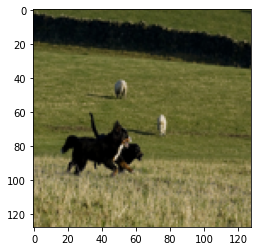

a dog running through a field


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Describes with minor errors" category since there are two dogs running through a field, while the caption states that only one dog is running through the field. The second dog, however, is hard to recognize since it is mostly behind the first dog. This is similar to an image classified as "Describes with minor errosr" in the paper.

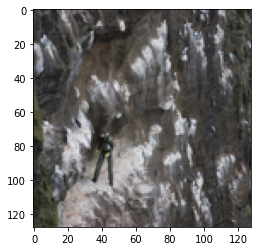

a man is climbing up a rock


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Describe with minor errors" category since the man is, indeed, on a rock, but the man does not seem to be climbing in this image (derived from the man looking down and not moving up).

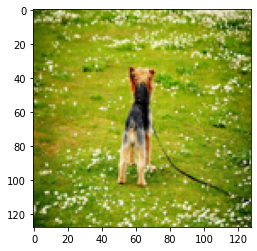

a dog is running through a field of grass


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Describe with minor errors" category since the dog in the image does not seem to be running through the field of grass. Rather, the dog seems to be standing in the field of grass.

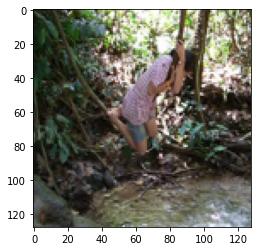

a man in a black shirt climbs a rock


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Unrelated to the image" category for multiple reasons. First of all, the person in the image cannot easily be identified as a man. Secondly, the person is not wearing a black shirt, and thirdly, the person is not climbing a rock, but rather clinging on to something.

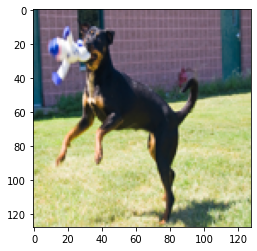

a black and white dog is running on a green yard


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Somewhat related to the image" category since there, indeed, is a dog in a green yard. The dog, however, does not seem to be running and is also not black and white, but black and brown.

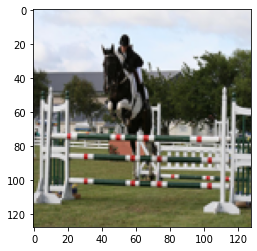

a man is doing a jump on a skateboard


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Unrelated to the image" category since the person in the image seems to be a woman rather than a man. Furthermore, the person is not doing a jump on a skateboard, but a jump on a horse.

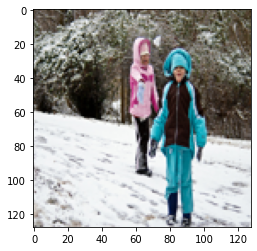

a man in a black coat is standing on a snowy hill


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Somewhat related to the image" category since the coat is not just black, it is also blue. Furthermore, there are two people on the snowy hill, who are not necessarily both a man. Girl or boy would fit better here, depending on the actual genders.

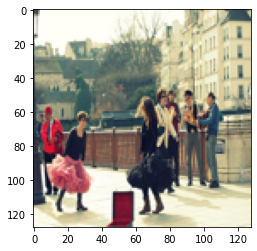

a group of people are standing on a sidewalk


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Describes without errors" category since we, indeed, observe a group of people that are standing on a sidewalk. One could argue that they might be dancing, but we cannot conclude this with certainty from the image.

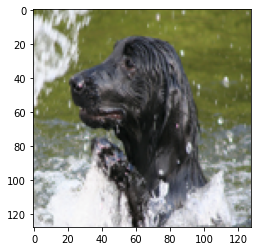

a black dog is swimming in the water


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Describes without errors" category since we, indeed, observe a black dog that is swimming in the water. We can derive the swimming from the splashes around the dog.

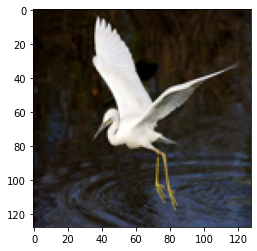

a white bird is flying through the water


In [ ]:
plot_image(input_images, decoded_preds)

We classify this image in the "Describe with minor errors" category since there is, indeed, a white bird flying, but the bird is, of course, not flying through the water, but over the water.

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

scores = {'BLEU-1':[], 'BLEU-2':[], 'BLEU-3':[], 'BLEU-4':[]}
for i in range(len(decoded_preds)):
  references = input_captions[i]
  candidate = decoded_preds[i].split()

  scores['BLEU-1'].append(sentence_bleu(references, candidate, weights=(1.0, 0, 0, 0, 0), 
                          smoothing_function=SmoothingFunction().method4))
  scores['BLEU-2'].append(sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0, 0), 
                          smoothing_function=SmoothingFunction().method4))
  scores['BLEU-3'].append(sentence_bleu(references, candidate, weights=(0.333, 0.333, 0.333, 0, 0), 
                          smoothing_function=SmoothingFunction().method4))
  scores['BLEU-4'].append(sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25, 0), 
                          smoothing_function=SmoothingFunction().method4))

scores['BLEU-1'] = np.average(scores['BLEU-1'])
scores['BLEU-2'] = np.average(scores['BLEU-2'])
scores['BLEU-3'] = np.average(scores['BLEU-3'])
scores['BLEU-4'] = np.average(scores['BLEU-4'])

print('BLEU-1', scores['BLEU-1'])
print('BLEU-2', scores['BLEU-2'])
print('BLEU-3', scores['BLEU-3'])
print('BLEU-4', scores['BLEU-4'])

BLEU-1 0.5221808093865231
BLEU-2 0.3661665878032931
BLEU-3 0.30353119007090035
BLEU-4 0.265739344746185
